## Using the dataset, build a model that can forecast ticket volume

In [1]:
# basic packages
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns

#data specific package
from pandas.tseries.holiday import USFederalHolidayCalendar

warnings.filterwarnings(
    action="ignore"
)

In [2]:
# importing dataset
df = pd.read_csv("Data/MR_DS.csv")

# data start and end date
start_date = '2015-11-24'
end_date = '2016-04-21'

In [3]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count
0,4/21/2016,533,984,507,239,240
1,4/20/2016,658,6035,485,225,210
2,4/19/2016,778,2450,500,196,231
3,4/18/2016,743,2502,527,192,240
4,4/17/2016,925,3080,488,217,209


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null object
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: int64(5), object(1)
memory usage: 7.1+ KB


In [5]:
# convert date to datetime object to apply transformations
df["Ticket Created Date"] = pd.to_datetime(df["Ticket Created Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null datetime64[ns]
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 7.1 KB


In [6]:
# create season feature: winter, spring, summer, fall
df["Season"] = "Winter"
df["Season"][(df["Ticket Created Date"].dt.month > 2) & (df["Ticket Created Date"].dt.month <= 5)]  = "Spring"
df["Season"][(df["Ticket Created Date"].dt.month > 5) & (df["Ticket Created Date"].dt.month <= 8)]  = "Summer"
df["Season"][(df["Ticket Created Date"].dt.month > 8) & (df["Ticket Created Date"].dt.month <= 11)]  = "Fall"
df.Season.unique()

array(['Spring', 'Winter', 'Fall'], dtype=object)

In [7]:
# linear model doesn't accept categories, one hot encoding to accommodate
one_hot = pd.get_dummies(df["Season"])
df = df.drop("Season", axis=1)
df = df.join(one_hot)

In [8]:
# create holiday feature
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)
df["Holiday"] = np.where(df["Ticket Created Date"].isin(holidays), "Holiday", "Not Holiday")
list(holidays)

[Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-01-18 00:00:00'),
 Timestamp('2016-02-15 00:00:00')]

In [9]:
one_hot = pd.get_dummies(df["Holiday"])
df = df.drop("Holiday", axis=1)
df = df.join(one_hot)

In [10]:
# check weekday vs weekend
df["Weekday"] = np.where(pd.DatetimeIndex(df["Ticket Created Date"]).weekday < 5, "Weekday", "Weekend")
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,Weekday
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,Weekday
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,Weekday
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,Weekday
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,Weekend


In [11]:
one_hot = pd.get_dummies(df["Weekday"])
df = df.drop("Weekday", axis=1)
df = df.join(one_hot)

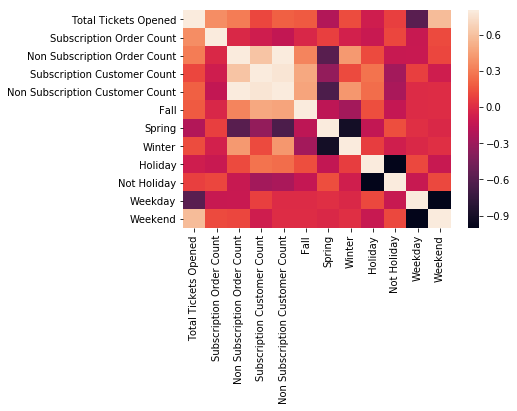

In [12]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [13]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday,Weekend
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,1,0
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,1,0
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,1,0
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,1,0
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,0,1


In [14]:
# original algorithm without any reduction
rgr = LinearRegression()
Y = df["Total Tickets Opened"]
X = df.iloc[:, 2:]

# splitting dataset into training data and testing data to validate model using holdout groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 4.39796662e-02  6.40476302e-01  7.93610138e-01 -1.48799655e+00
  1.24523411e+02 -8.12810279e+01 -4.32423827e+01 -2.66393304e+01
  2.66393304e+01 -1.23496216e+02  1.23496216e+02]

Intercept: 
 553.7021650658478

Accuracy:
 0.5455183062896066


In [15]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [-0.36662328  0.47158095  0.61884403]


In [16]:
# try to simplify equation based on correlation heatmap; keeping all seasons
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Spring", "Winter", "Holiday", "Weekday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 5.29338257e-02  3.22380703e-01  1.25812776e+02 -1.08023633e+02
 -1.77891437e+01 -1.24108514e+01 -2.12056711e+02]

Intercept: 
 688.7049948777393

Accuracy:
 0.6528665896307474


In [17]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [-0.6470768   0.46776428  0.28244374]


In [18]:
# further simplification, although because dataset doesn't include any "Summer", may have adverse effects with inclusion of summer data
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Winter", "Holiday", "Weekday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 4.33572896e-02  2.86586749e-01  1.98688698e+02  7.46715293e+01
 -6.44292723e+01 -2.25513751e+02]

Intercept: 
 638.8020007486762

Accuracy:
 0.5962827864546478


In [19]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.20073476  0.35014223 -0.31542238]


In [20]:
# instead of weekday v weekend, check day
df = df.drop(['Weekday', 'Weekend'], axis=1)

In [21]:
df['Day of Week'] = pd.DatetimeIndex(df["Ticket Created Date"]).weekday
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 6, 'Sunday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 5, 'Saturday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 4, 'Friday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 3, 'Thursday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 2, 'Wednesday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 1, 'Tuesday')
df['Day of Week'] = df['Day of Week'].where(df['Day of Week'] != 0, 'Monday')
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Day of Week
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,Thursday
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,Wednesday
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,Tuesday
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,Monday
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,Sunday


In [22]:
one_hot = pd.get_dummies(df["Day of Week"])
df = df.drop("Day of Week", axis=1)
df = df.join(one_hot)

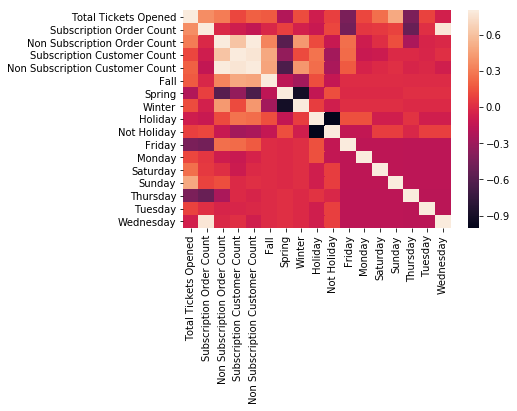

In [23]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [24]:
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Winter", "Holiday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 3.80094517e-02  6.78704300e-01  9.55330484e+01  6.24537228e+00
 -4.79870799e+01  5.13654207e+01  1.19257571e+01 -1.25014095e+02
 -1.50274184e+02 -1.73730316e+02  1.52108528e+02  2.33618889e+02]

Intercept: 
 445.5521044152097

Accuracy:
 0.6954570647323273


In [25]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.51159304 -0.00886051  0.75721736]


In [26]:
# combining both Weekday v Weekend versus day of the week
df["Weekday"] = np.where(pd.DatetimeIndex(df["Ticket Created Date"]).weekday < 5, "Weekday", "Weekend")
one_hot = pd.get_dummies(df["Weekday"])
df = df.drop("Weekday", axis=1)
df = df.join(one_hot)

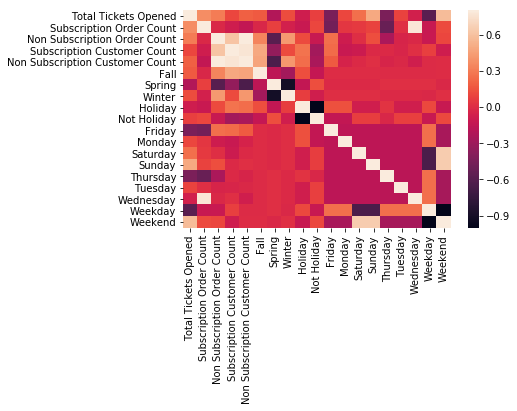

In [27]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [28]:
# some correlation between weekend and sunday and saturday
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Winter", "Holiday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Weekend", "Weekday"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
rgr.fit(X_train, Y_train)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nAccuracy:\n', rgr.score(X_train, Y_train))


Coefficients: 
 [ 3.77377026e-02  5.25058283e-01  1.61628117e+02  6.84145079e+01
 -6.73429044e+01  1.05014397e+02  9.06809805e+01 -8.74534618e+01
 -9.79000523e+01 -1.09172177e+02  9.88303137e+01 -9.88303137e+01]

Intercept: 
 497.2114778634548

Accuracy:
 0.7464343612753344


In [29]:
print('\nCross Validation of test data:\n',cross_val_score(rgr, X_test, Y_test, cv=3))


Cross Validation of test data:
 [ 0.1020345  -0.24676144  0.34913649]


In [30]:
# day of week is more accurate than weekday & weekend, and combining both isn't significantly accurate. keep just day of week for coherency
df = df.drop(['Weekday', 'Weekend'], axis=1)
df.to_csv("Data/Modified_MR_DS.csv")